## Crypto Prediction with LSTM: BitCoin (BTC)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt

import nasdaqdatalink

from api_keys import coinapi_key

2023-09-26 15:56:45.589949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-26T00:00:00.0000000Z', 'time_period_end': '2023-09-27T00:00:00.0000000Z', 'time_open': '2023-09-26T00:00:06.1980000Z', 'time_close': '2023-09-26T19:56:42.3650000Z', 'price_open': 26298, 'price_high': 26386, 'price_low': 26085, 'price_close': 26257, 'volume_traded': 713.23291201, 'trades_count': 7600}, {'time_period_start': '2023-09-25T00:00:00.0000000Z', 'time_period_end': '2023-09-26T00:00:00.0000000Z', 'time_open': '2023-09-25T00:00:36.5920000Z', 'time_close': '2023-09-25T23:59:50.7220000Z', 'price_open': 26215, 'price_high': 26436, 'price_low': 25977, 'price_close': 26297, 'volume_traded': 1287.13732124, 'trades_count': 12657}, {'time_period_start': '2023-09-24T00:00:00.0000000Z', 'time_period_end': '2023-09-25T00:00:00.0000000Z', 'time_open': '2023-09-24T00:00:08.2420000Z', 'time_close': '2023-09-24T23:59:38.0250000Z', 'price_open': 26582, 'price_high': 26730, 'price_low': 26148, 'price_close': 26248, 'volume_traded': 772.76467653, 'trades_count': 70

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-26T00:00:00.0000000Z,2023-09-27T00:00:00.0000000Z,2023-09-26T00:00:06.1980000Z,2023-09-26T19:56:42.3650000Z,26298.0,26386.0,26085.0,26257.0,713.232912,7600
1,2023-09-25T00:00:00.0000000Z,2023-09-26T00:00:00.0000000Z,2023-09-25T00:00:36.5920000Z,2023-09-25T23:59:50.7220000Z,26215.0,26436.0,25977.0,26297.0,1287.137321,12657
2,2023-09-24T00:00:00.0000000Z,2023-09-25T00:00:00.0000000Z,2023-09-24T00:00:08.2420000Z,2023-09-24T23:59:38.0250000Z,26582.0,26730.0,26148.0,26248.0,772.764677,7003
3,2023-09-23T00:00:00.0000000Z,2023-09-24T00:00:00.0000000Z,2023-09-23T00:00:25.3130000Z,2023-09-23T23:59:56.6920000Z,26577.0,26634.0,26519.0,26583.0,263.353084,6413
4,2023-09-22T00:00:00.0000000Z,2023-09-23T00:00:00.0000000Z,2023-09-22T00:00:44.2630000Z,2023-09-22T23:59:12.5270000Z,26568.0,26733.0,26479.0,26581.0,681.445938,10407


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2011-09-13,5.97
2011-09-14,5.53
2011-09-15,5.13
2011-09-16,4.85
2011-09-17,4.87


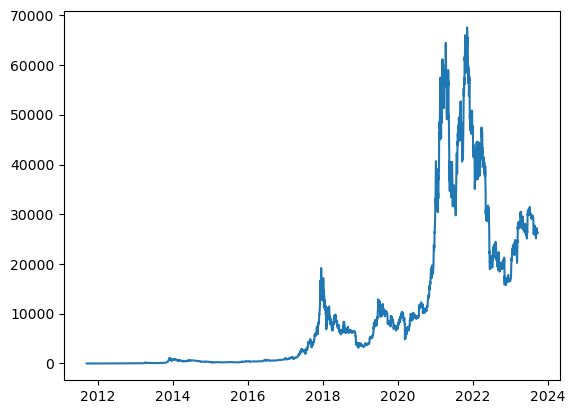

In [5]:
#plot historical amzn price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#Scale data
log_transformed_data = np.log(shifted_df_as_np)



# split reference from deatures
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((4237, 7), (4237,), (4237,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((3389, 7), (3389,), (424, 7), (424,), (424, 7), (424,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-26 15:57:00.625014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
106/106 [==============================] - 11s 33ms/step - loss: 7.8433 - mean_absolute_error: 1.7205 - val_loss: 0.1610 - val_mean_absolute_error: 0.3788
Epoch 2/100
106/106 [==============================] - 1s 11ms/step - loss: 0.0103 - mean_absolute_error: 0.0664 - val_loss: 0.0190 - val_mean_absolute_error: 0.1173
Epoch 3/100
106/106 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_absolute_error: 0.0518 - val_loss: 0.0057 - val_mean_absolute_error: 0.0599
Epoch 4/100
106/106 [==============================] - 1s 12ms/step - loss: 0.0054 - mean_absolute_error: 0.0520 - val_loss: 0.0055 - val_mean_absolute_error: 0.0592
Epoch 5/100
106/106 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_absolute_error: 0.0510 - val_loss: 0.0044 - val_mean_absolute_error: 0.0522
Epoch 6/100
106/106 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_absolute_error: 0.0468 - val_loss: 0.0037 - val_mean_absolute_error: 0.0477
Epo

106/106 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_absolute_error: 0.0378 - val_loss: 0.0020 - val_mean_absolute_error: 0.0341
Epoch 51/100
106/106 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_absolute_error: 0.0436 - val_loss: 0.0043 - val_mean_absolute_error: 0.0553
Epoch 52/100
106/106 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_absolute_error: 0.0462 - val_loss: 0.0019 - val_mean_absolute_error: 0.0334
Epoch 53/100
106/106 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_absolute_error: 0.0368 - val_loss: 0.0016 - val_mean_absolute_error: 0.0301
Epoch 54/100
106/106 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_absolute_error: 0.0392 - val_loss: 0.0063 - val_mean_absolute_error: 0.0702
Epoch 55/100
106/106 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_absolute_error: 0.0411 - val_loss: 0.0124 - val_mean_absolute_error: 0.1040
Epoch 56/10

106/106 [==============================] - 1s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0383 - val_loss: 0.0052 - val_mean_absolute_error: 0.0633
Epoch 100/100
106/106 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0420 - val_loss: 0.0021 - val_mean_absolute_error: 0.0358


106/106 [==============================] - 2s 4ms/step


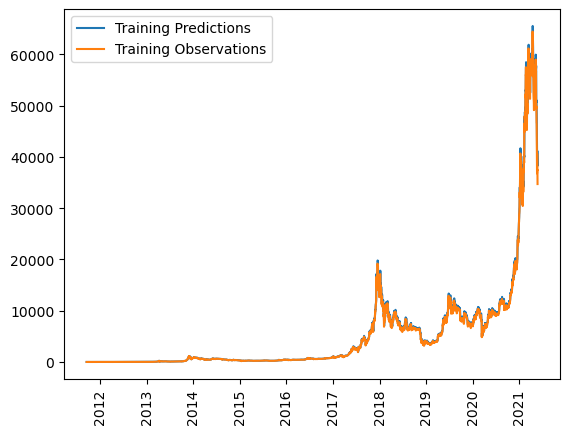

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0020963577553629875
Val MAE: 0.03575785085558891


14/14 [==============================] - 0s 4ms/step


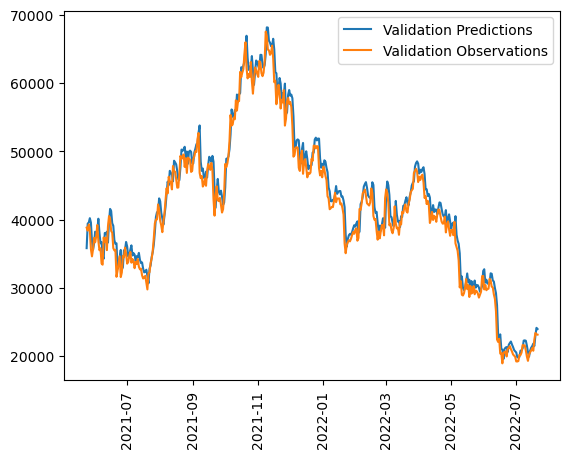

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0015593940624967217
Test MAE: 0.03361205384135246


14/14 [==============================] - 0s 8ms/step


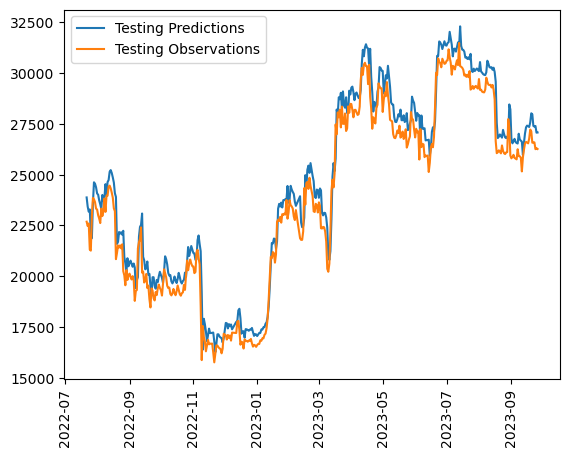

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.95880139768386


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((1652,),
 (1652, 7),
 (1652,),
 (255,),
 (255, 7),
 (255,),
 (212,),
 (212, 7),
 (212,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
106/106 [==============================] - 20s 46ms/step - loss: 41.3221 - mean_absolute_error: 5.9256 - val_loss: 64.4149 - val_mean_absolute_error: 8.0206
Epoch 2/300
106/106 [==============================] - 1s 12ms/step - loss: 9.2068 - mean_absolute_error: 2.4155 - val_loss: 10.7645 - val_mean_absolute_error: 3.2679
Epoch 3/300
106/106 [==============================] - 1s 11ms/step - loss: 1.7039 - mean_absolute_error: 1.1753 - val_loss: 5.7340 - val_mean_absolute_error: 2.3791
Epoch 4/300
106/106 [==============================] - 1s 12ms/step - loss: 0.7215 - mean_absolute_error: 0.7365 - val_loss: 2.9616 - val_mean_absolute_error: 1.7052
Epoch 5/300
106/106 [==============================] - 1s 12ms/step - loss: 0.2812 - mean_absolute_error: 0.4300 - val_loss: 1.3441 - val_mean_absolute_error: 1.1426
Epoch 6/300
106/106 [==============================] - 1s 12ms/step - loss: 0.0999 - mean_absolute_error: 0.2354 - val_loss: 0.6045 - val_mean_absolute_error: 0.7591


106/106 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_absolute_error: 0.0425 - val_loss: 0.0034 - val_mean_absolute_error: 0.0446
Epoch 51/300
106/106 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_absolute_error: 0.0408 - val_loss: 0.0026 - val_mean_absolute_error: 0.0394
Epoch 52/300
106/106 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_absolute_error: 0.0414 - val_loss: 0.0035 - val_mean_absolute_error: 0.0453
Epoch 53/300
106/106 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_absolute_error: 0.0425 - val_loss: 0.0048 - val_mean_absolute_error: 0.0549
Epoch 54/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0041 - mean_absolute_error: 0.0418 - val_loss: 0.0030 - val_mean_absolute_error: 0.0417
Epoch 55/300
106/106 [==============================] - 2s 17ms/step - loss: 0.0039 - mean_absolute_error: 0.0406 - val_loss: 0.0025 - val_mean_absolute_error: 0.0390
Epoch 56/30

106/106 [==============================] - 1s 9ms/step - loss: 0.0033 - mean_absolute_error: 0.0371 - val_loss: 0.0035 - val_mean_absolute_error: 0.0465
Epoch 100/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0367 - val_loss: 0.0019 - val_mean_absolute_error: 0.0333
Epoch 101/300
106/106 [==============================] - 1s 10ms/step - loss: 0.0033 - mean_absolute_error: 0.0370 - val_loss: 0.0027 - val_mean_absolute_error: 0.0399
Epoch 102/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0353 - val_loss: 0.0024 - val_mean_absolute_error: 0.0369
Epoch 103/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0352 - val_loss: 0.0018 - val_mean_absolute_error: 0.0330
Epoch 104/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0352 - val_loss: 0.0022 - val_mean_absolute_error: 0.0370
Epoch 105/3

106/106 [==============================] - 1s 8ms/step - loss: 0.0028 - mean_absolute_error: 0.0332 - val_loss: 0.0026 - val_mean_absolute_error: 0.0405
Epoch 149/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0028 - mean_absolute_error: 0.0332 - val_loss: 0.0016 - val_mean_absolute_error: 0.0311
Epoch 150/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0334 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302
Epoch 151/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0029 - mean_absolute_error: 0.0351 - val_loss: 0.0024 - val_mean_absolute_error: 0.0399
Epoch 152/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0029 - mean_absolute_error: 0.0340 - val_loss: 0.0034 - val_mean_absolute_error: 0.0473
Epoch 153/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0335 - val_loss: 0.0015 - val_mean_absolute_error: 0.0297
Epoch 154/30

106/106 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0322 - val_loss: 0.0015 - val_mean_absolute_error: 0.0291
Epoch 198/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0331 - val_loss: 0.0021 - val_mean_absolute_error: 0.0373
Epoch 199/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0332 - val_loss: 0.0048 - val_mean_absolute_error: 0.0609
Epoch 200/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0028 - mean_absolute_error: 0.0330 - val_loss: 0.0016 - val_mean_absolute_error: 0.0292
Epoch 201/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0324 - val_loss: 0.0018 - val_mean_absolute_error: 0.0318
Epoch 202/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0327 - val_loss: 0.0018 - val_mean_absolute_error: 0.0319
Epoch 203/30

106/106 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0334 - val_loss: 0.0018 - val_mean_absolute_error: 0.0319
Epoch 247/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0335 - val_loss: 0.0030 - val_mean_absolute_error: 0.0461
Epoch 248/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0026 - mean_absolute_error: 0.0323 - val_loss: 0.0018 - val_mean_absolute_error: 0.0320
Epoch 249/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0329 - val_loss: 0.0017 - val_mean_absolute_error: 0.0313
Epoch 250/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0315 - val_loss: 0.0027 - val_mean_absolute_error: 0.0419
Epoch 251/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0326 - val_loss: 0.0016 - val_mean_absolute_error: 0.0297
Epoch 252/30

106/106 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0319 - val_loss: 0.0015 - val_mean_absolute_error: 0.0287
Epoch 296/300
106/106 [==============================] - 1s 9ms/step - loss: 0.0026 - mean_absolute_error: 0.0327 - val_loss: 0.0017 - val_mean_absolute_error: 0.0312
Epoch 297/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0329 - val_loss: 0.0022 - val_mean_absolute_error: 0.0370
Epoch 298/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0325 - val_loss: 0.0014 - val_mean_absolute_error: 0.0283
Epoch 299/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0314 - val_loss: 0.0016 - val_mean_absolute_error: 0.0304
Epoch 300/300
106/106 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0334 - val_loss: 0.0018 - val_mean_absolute_error: 0.0325


52/52 [==============================] - 1s 3ms/step


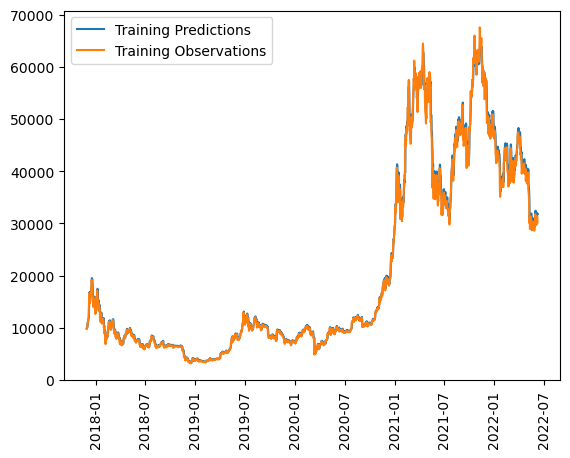

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0015406375750899315
Val MAE: 0.02947286330163479


8/8 [==============================] - 0s 6ms/step


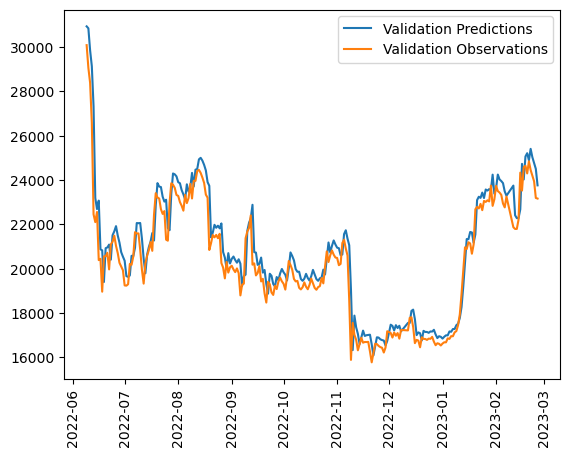

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.000995410606265068
Test MAE: 0.026953674852848053


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

7/7 [==============================] - 0s 5ms/step
R2 Score:  0.8548393800198129


7/7 [==============================] - 0s 3ms/step


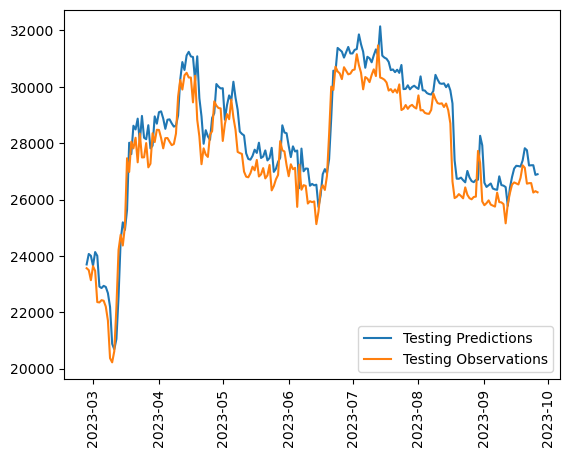

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64, return_sequences=True),
                    layers.LSTM(64, return_sequences=False),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
52/52 [==============================] - 8s 43ms/step - loss: 33.8195 - mean_absolute_error: 4.7695 - val_loss: 0.2118 - val_mean_absolute_error: 0.4420
Epoch 2/300
52/52 [==============================] - 1s 16ms/step - loss: 0.8321 - mean_absolute_error: 0.7767 - val_loss: 0.2349 - val_mean_absolute_error: 0.4675
Epoch 3/300
52/52 [==============================] - 1s 16ms/step - loss: 0.7447 - mean_absolute_error: 0.7606 - val_loss: 0.1661 - val_mean_absolute_error: 0.3870
Epoch 4/300
52/52 [==============================] - 1s 16ms/step - loss: 0.7486 - mean_absolute_error: 0.7609 - val_loss: 0.1680 - val_mean_absolute_error: 0.3894
Epoch 5/300
52/52 [==============================] - 1s 16ms/step - loss: 0.7464 - mean_absolute_error: 0.7482 - val_loss: 0.0295 - val_mean_absolute_error: 0.1459
Epoch 6/300
52/52 [==============================] - 1s 16ms/step - loss: 0.7539 - mean_absolute_error: 0.7638 - val_loss: 0.1447 - val_mean_absolute_error: 0.3583
Epoch 7/300
52/

Epoch 51/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0069 - mean_absolute_error: 0.0630 - val_loss: 0.0061 - val_mean_absolute_error: 0.0589
Epoch 52/300
52/52 [==============================] - 1s 17ms/step - loss: 0.0084 - mean_absolute_error: 0.0721 - val_loss: 0.0039 - val_mean_absolute_error: 0.0409
Epoch 53/300
52/52 [==============================] - 1s 21ms/step - loss: 0.0072 - mean_absolute_error: 0.0645 - val_loss: 0.0055 - val_mean_absolute_error: 0.0545
Epoch 54/300
52/52 [==============================] - 1s 20ms/step - loss: 0.0082 - mean_absolute_error: 0.0706 - val_loss: 0.0067 - val_mean_absolute_error: 0.0684
Epoch 55/300
52/52 [==============================] - 1s 19ms/step - loss: 0.0079 - mean_absolute_error: 0.0679 - val_loss: 0.0173 - val_mean_absolute_error: 0.1229
Epoch 56/300
52/52 [==============================] - 1s 20ms/step - loss: 0.0087 - mean_absolute_error: 0.0710 - val_loss: 0.0076 - val_mean_absolute_error: 0.0680
Epoch 57/3

Epoch 101/300
52/52 [==============================] - 1s 13ms/step - loss: 0.0059 - mean_absolute_error: 0.0589 - val_loss: 0.0035 - val_mean_absolute_error: 0.0413
Epoch 102/300
52/52 [==============================] - 1s 13ms/step - loss: 0.0054 - mean_absolute_error: 0.0559 - val_loss: 0.0041 - val_mean_absolute_error: 0.0504
Epoch 103/300
52/52 [==============================] - 1s 13ms/step - loss: 0.0062 - mean_absolute_error: 0.0601 - val_loss: 0.0043 - val_mean_absolute_error: 0.0450
Epoch 104/300
52/52 [==============================] - 1s 12ms/step - loss: 0.0069 - mean_absolute_error: 0.0646 - val_loss: 0.0047 - val_mean_absolute_error: 0.0549
Epoch 105/300
52/52 [==============================] - 1s 13ms/step - loss: 0.0069 - mean_absolute_error: 0.0646 - val_loss: 0.0042 - val_mean_absolute_error: 0.0518
Epoch 106/300
52/52 [==============================] - 1s 15ms/step - loss: 0.0072 - mean_absolute_error: 0.0669 - val_loss: 0.0039 - val_mean_absolute_error: 0.0418
Epoc

52/52 [==============================] - 1s 16ms/step - loss: 0.0052 - mean_absolute_error: 0.0562 - val_loss: 0.0028 - val_mean_absolute_error: 0.0391
Epoch 151/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_absolute_error: 0.0599 - val_loss: 0.0034 - val_mean_absolute_error: 0.0409
Epoch 152/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0058 - mean_absolute_error: 0.0590 - val_loss: 0.0031 - val_mean_absolute_error: 0.0362
Epoch 153/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0053 - mean_absolute_error: 0.0568 - val_loss: 0.0099 - val_mean_absolute_error: 0.0874
Epoch 154/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0049 - mean_absolute_error: 0.0533 - val_loss: 0.0056 - val_mean_absolute_error: 0.0593
Epoch 155/300
52/52 [==============================] - 1s 15ms/step - loss: 0.0043 - mean_absolute_error: 0.0494 - val_loss: 0.0074 - val_mean_absolute_error: 0.0785
Epoch 156/300
52/5

52/52 [==============================] - 1s 16ms/step - loss: 0.0043 - mean_absolute_error: 0.0509 - val_loss: 0.0045 - val_mean_absolute_error: 0.0597
Epoch 200/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0022 - val_mean_absolute_error: 0.0330
Epoch 201/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_absolute_error: 0.0458 - val_loss: 0.0016 - val_mean_absolute_error: 0.0278
Epoch 202/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_absolute_error: 0.0522 - val_loss: 0.0038 - val_mean_absolute_error: 0.0537
Epoch 203/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0039 - mean_absolute_error: 0.0488 - val_loss: 0.0018 - val_mean_absolute_error: 0.0276
Epoch 204/300
52/52 [==============================] - 1s 18ms/step - loss: 0.0030 - mean_absolute_error: 0.0412 - val_loss: 0.0015 - val_mean_absolute_error: 0.0254
Epoch 205/300
52/5

52/52 [==============================] - 1s 16ms/step - loss: 0.0035 - mean_absolute_error: 0.0451 - val_loss: 0.0041 - val_mean_absolute_error: 0.0564
Epoch 249/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_absolute_error: 0.0486 - val_loss: 0.0039 - val_mean_absolute_error: 0.0560
Epoch 250/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0030 - mean_absolute_error: 0.0424 - val_loss: 0.0027 - val_mean_absolute_error: 0.0425
Epoch 251/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0024 - mean_absolute_error: 0.0357 - val_loss: 0.0015 - val_mean_absolute_error: 0.0279
Epoch 252/300
52/52 [==============================] - 1s 17ms/step - loss: 0.0031 - mean_absolute_error: 0.0425 - val_loss: 0.0047 - val_mean_absolute_error: 0.0632
Epoch 253/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0027 - mean_absolute_error: 0.0393 - val_loss: 0.0038 - val_mean_absolute_error: 0.0537
Epoch 254/300
52/5

52/52 [==============================] - 1s 16ms/step - loss: 0.0029 - mean_absolute_error: 0.0406 - val_loss: 0.0013 - val_mean_absolute_error: 0.0247
Epoch 298/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0024 - mean_absolute_error: 0.0356 - val_loss: 0.0014 - val_mean_absolute_error: 0.0270
Epoch 299/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0036 - mean_absolute_error: 0.0470 - val_loss: 0.0013 - val_mean_absolute_error: 0.0240
Epoch 300/300
52/52 [==============================] - 1s 17ms/step - loss: 0.0025 - mean_absolute_error: 0.0375 - val_loss: 0.0027 - val_mean_absolute_error: 0.0459


52/52 [==============================] - 2s 5ms/step


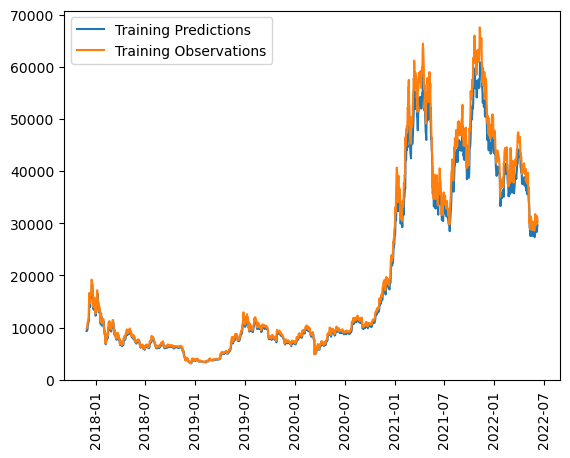

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.002741617616266012
Val MAE: 0.0459226630628109


8/8 [==============================] - 0s 6ms/step


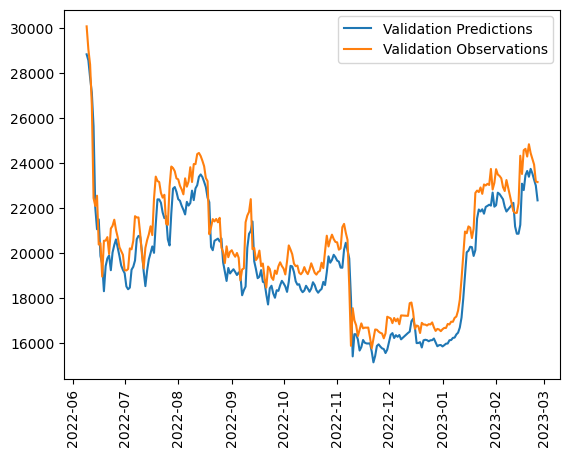

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0027093084063380957
Test MAE: 0.04787652939558029


7/7 [==============================] - 0s 6ms/step


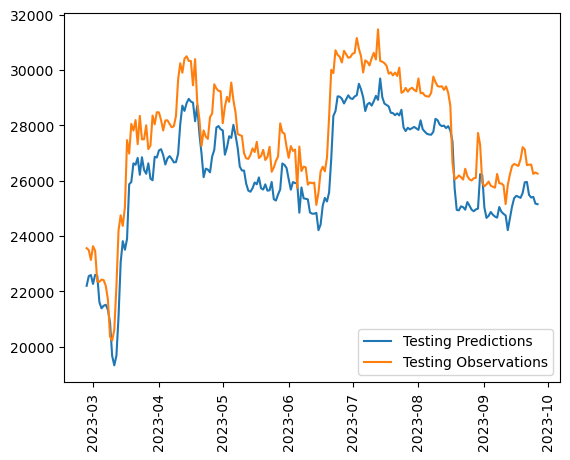

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.60490210597105


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [32]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 35ms/step
[10.206104, 10.209602, 10.208848, 10.208556, 10.208839, 10.208883, 10.208692]
2023-09-27
2023-09-28
2023-09-29
2023-09-30
2023-10-01
2023-10-02
2023-10-03


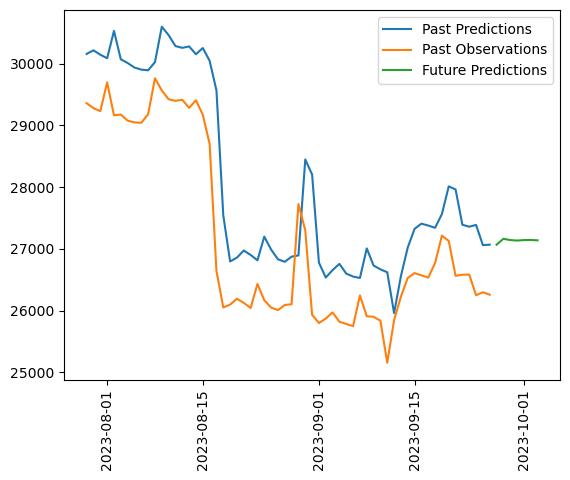

In [33]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [34]:
# Export model1 to HDF5 file
model.save("H5_Files/btc_7_day_1.h5")

In [35]:
# Export model2 to HDF5 file
model2.save("H5_Files/btc_7_day_2.h5")

In [36]:
# Export model to HDF5 file
model3.save("H5_Files/btc_7_day_3.h5")

In [37]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)

# df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
# df2.set_index('Date', inplace=True)                   
                    
# past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-06-29,30444.0,31553.861328,31415.654297,29087.248047
2023-06-30,30469.0,31361.261719,31185.089844,28981.365234
2023-07-01,30592.0,31338.871094,31185.564453,28953.658203
2023-07-02,30616.0,31468.007812,31312.460938,29043.896484
2023-07-03,31158.0,31506.714844,31341.619141,29089.607422
...,...,...,...,...
2023-09-22,26581.0,27390.453125,27208.109375,25488.283203
2023-09-23,26583.0,27358.812500,27216.050781,25393.611328
2023-09-24,26248.0,27387.660156,27217.685547,25414.130859


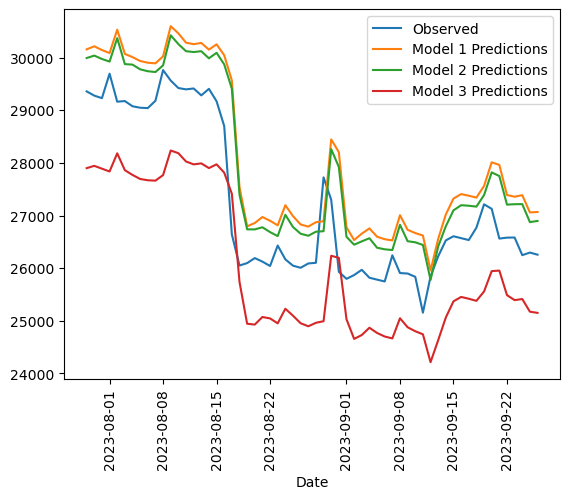

In [38]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [39]:
#output prediction data to csv
df.to_csv('output/btc_predict.csv') 

In [40]:
#output original historical data to csv
data.to_csv('output/btc_lifetime.csv')

In [41]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.95880139768386
Model 2 R2 Score:  0.8548393800198129
Model 3 R2 Score:  0.60490210597105
